In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Flatten, Reshape, Lambda, Dense, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import mse

In [2]:
# Define a custom accuracy metric
def accuracy(y_true, y_pred):
    threshold = 0.1
    diff = tf.abs(y_true - y_pred)
    correct = tf.cast(diff < threshold, tf.float32)
    accuracy = tf.reduce_mean(correct)
    return accuracy


In [3]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
# Reshape data to fit the network input
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [5]:
# Introduce noise in the dataset
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)



In [6]:
# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [12]:
input_shape = (28, 28, 1)
# Build the convolutional autoencoder
input_img = Input(shape=(28, 28, 1))
latent_dim = 2  # Dimensionality of the latent space

In [14]:
# Encoder
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)


In [15]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [17]:
# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(14 * 14 * 128, activation='relu')(decoder_input)
x = Reshape((14, 14, 128))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

In [18]:
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoded, name='decoder')
output = decoder(encoder(input_img)[2])
hvae = Model(input_img, output, name='hvae')

In [19]:
# Define the HVAE loss
reconstruction_loss = MeanSquaredError()(K.flatten(input_img), K.flatten(output))
reconstruction_loss *= 28 * 28

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

l2_loss = K.sum(K.square(z_mean), axis=-1) + K.sum(K.square(z_log_var), axis=-1)

hvae_loss = K.mean(reconstruction_loss + kl_loss+l2_loss)
hvae.add_loss(hvae_loss)
hvae.compile(optimizer='adam', metrics=['accuracy'])

In [20]:
# Train the HVAE
history2=hvae.fit(x_train_noisy, x_train,
         epochs=200,
         batch_size=256,
         shuffle=True,
         validation_split=0.1)

Epoch 1/200
211/211 [==============================] - 39s 173ms/step - loss: 104.0950 - accuracy: 0.7146 - val_loss: 99.9267 - val_accuracy: 0.6925
Epoch 2/200
211/211 [==============================] - 36s 173ms/step - loss: 99.9274 - accuracy: 0.6923 - val_loss: 99.9136 - val_accuracy: 0.6917
Epoch 3/200
211/211 [==============================] - 36s 170ms/step - loss: 99.9101 - accuracy: 0.6920 - val_loss: 99.8727 - val_accuracy: 0.6922
Epoch 4/200
211/211 [==============================] - 38s 180ms/step - loss: 99.9104 - accuracy: 0.6920 - val_loss: 99.8718 - val_accuracy: 0.6910
Epoch 5/200
211/211 [==============================] - 40s 187ms/step - loss: 99.9050 - accuracy: 0.6918 - val_loss: 99.8782 - val_accuracy: 0.6928
Epoch 6/200
211/211 [==============================] - 41s 192ms/step - loss: 99.9069 - accuracy: 0.6919 - val_loss: 99.8846 - val_accuracy: 0.6922
Epoch 7/200
211/211 [==============================] - 39s 184ms/step - loss: 99.8985 - accuracy: 0.6920 - val_

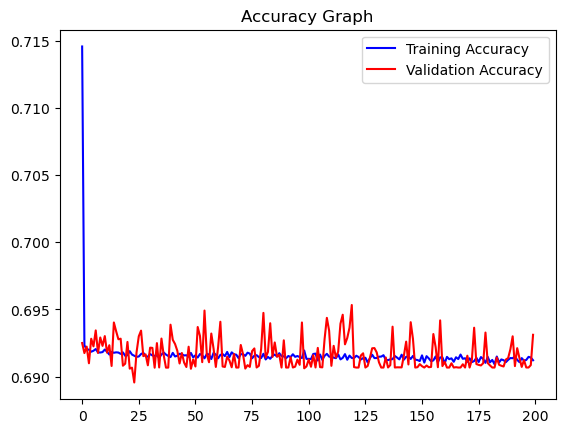

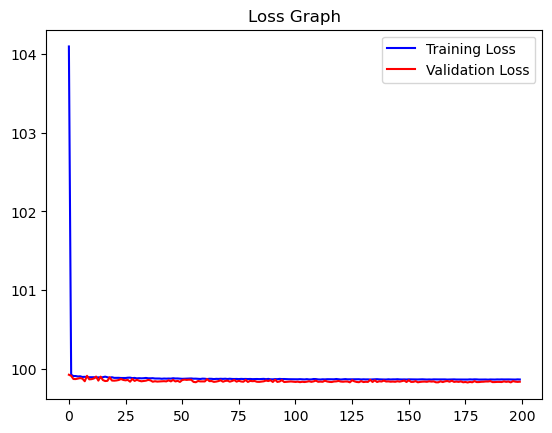

In [21]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc, 'b' ,label='Training Accuracy')
plt.plot(epochs,val_acc, 'r',label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss, 'b' ,label='Training Loss')
plt.plot(epochs,val_loss, 'r',label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [22]:
# Predict denoised images
x_test_denoised = hvae.predict(x_test_noisy)


313/313 [==============================] - 3s 9ms/step


In [37]:
# Function to plot original, noisy, and denoised images
def plot_images(original, noisy, denoised, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="binary")
        plt.title("Original")
        plt.axis("off")

        # Display noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap="binary")
        plt.title("Noisy")
        plt.axis("off")

        # Display denoised
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap="binary")
        plt.title("Denoised")
        plt.axis("off")
    plt.show()


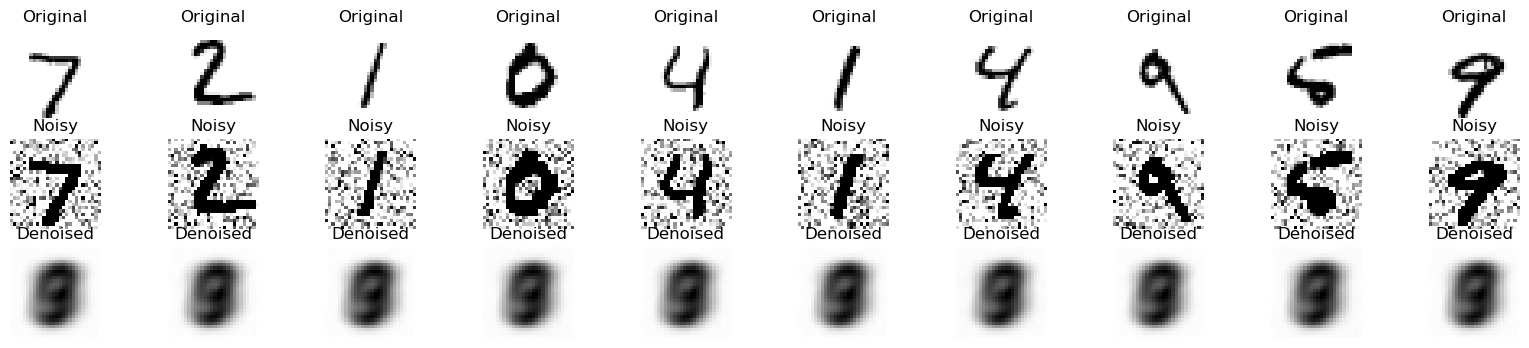

In [38]:
# Plot the original, noisy, and denoised images
plot_images(x_test, x_test_noisy, x_test_denoised)


In [39]:
# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(x_test - x_test_denoised), axis=(1, 2, 3))



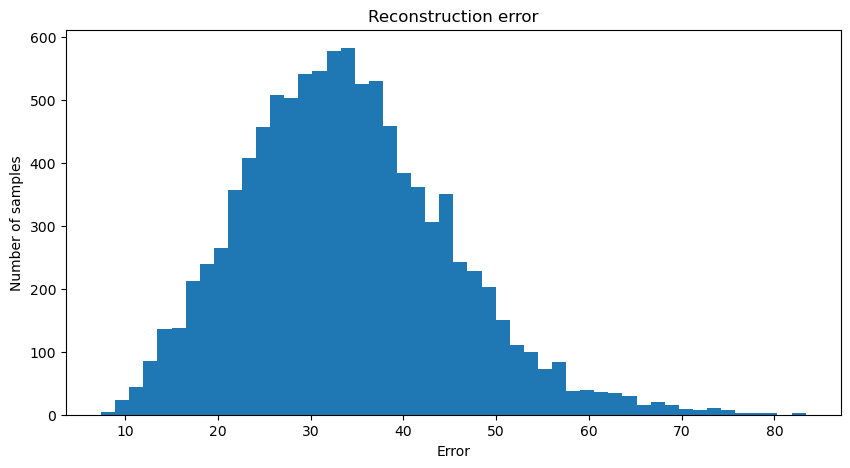

In [40]:
# Plot reconstruction error
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50)
plt.title("Reconstruction error")
plt.xlabel("Error")
plt.ylabel("Number of samples")
plt.show()


In [41]:
# Set a threshold for outliers based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # For example, 95th percentile
outliers = reconstruction_error > threshold


In [42]:
# Print the number of outliers detected
print(f"Number of outliers detected: {np.sum(outliers)}")



Number of outliers detected: 500


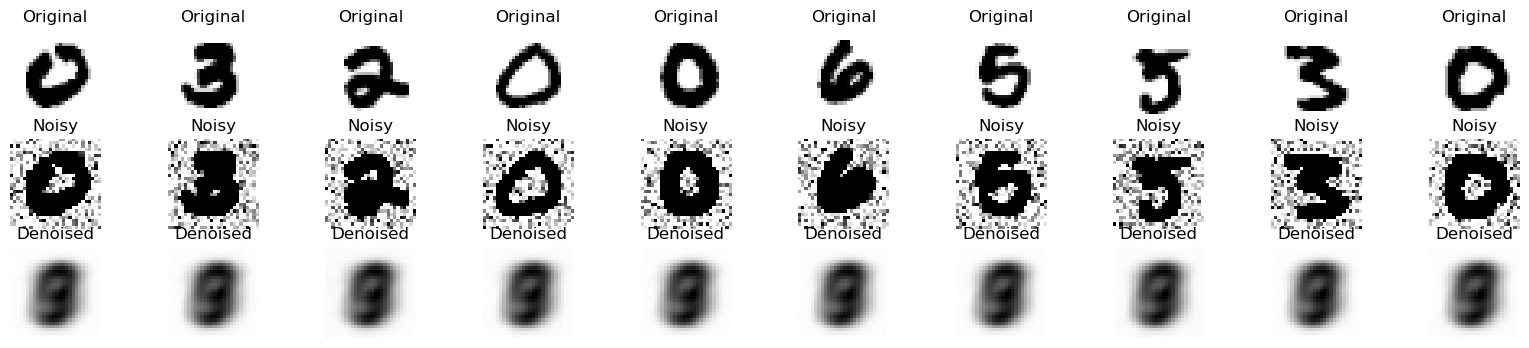

In [43]:
plot_images(x_test[outliers][:10], x_test_noisy[outliers][:10], x_test_denoised[outliers][:10], n=10)


In [44]:
# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(x_test - x_test_denoised), axis=(1, 2, 3))

# Set a threshold for outliers based on reconstruction error (95th percentile)
threshold = np.percentile(reconstruction_error, 95)


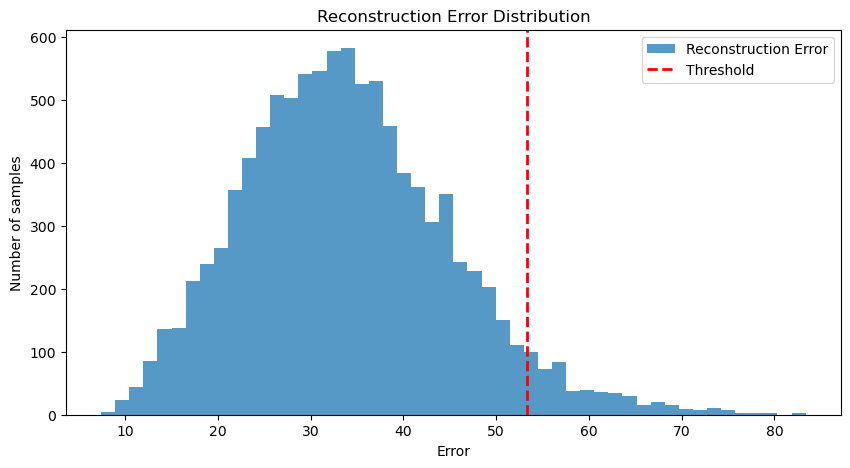

In [45]:
# Plot the reconstruction error distribution
def plot_reconstruction_error(reconstruction_error, threshold):
    plt.figure(figsize=(10, 5))
    plt.hist(reconstruction_error, bins=50, alpha=0.75, label='Reconstruction Error')
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Number of samples')
    plt.legend(loc='upper right')
    plt.show()

plot_reconstruction_error(reconstruction_error, threshold)


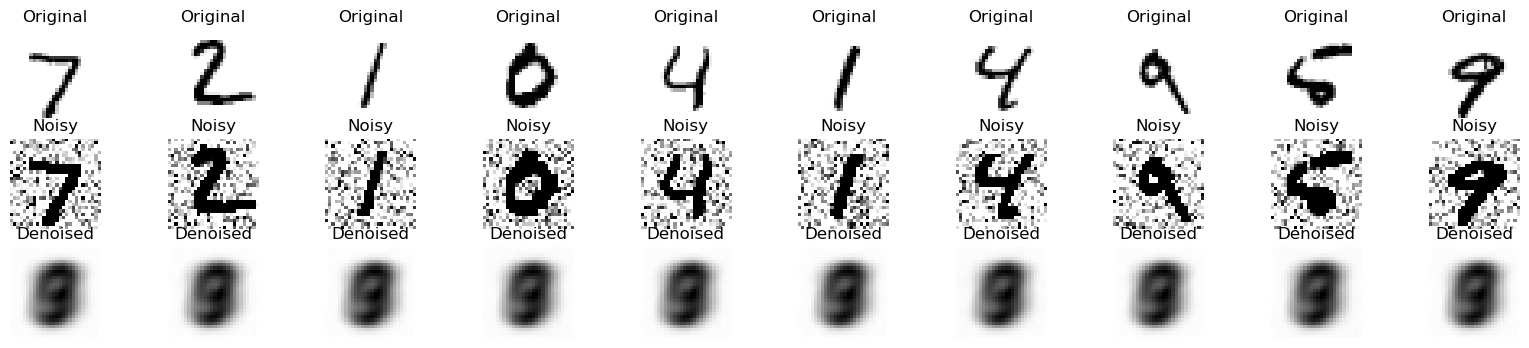

In [46]:
# Plot some sample images
plot_images(x_test, x_test_noisy, x_test_denoised)


313/313 [==============================] - 3s 9ms/step


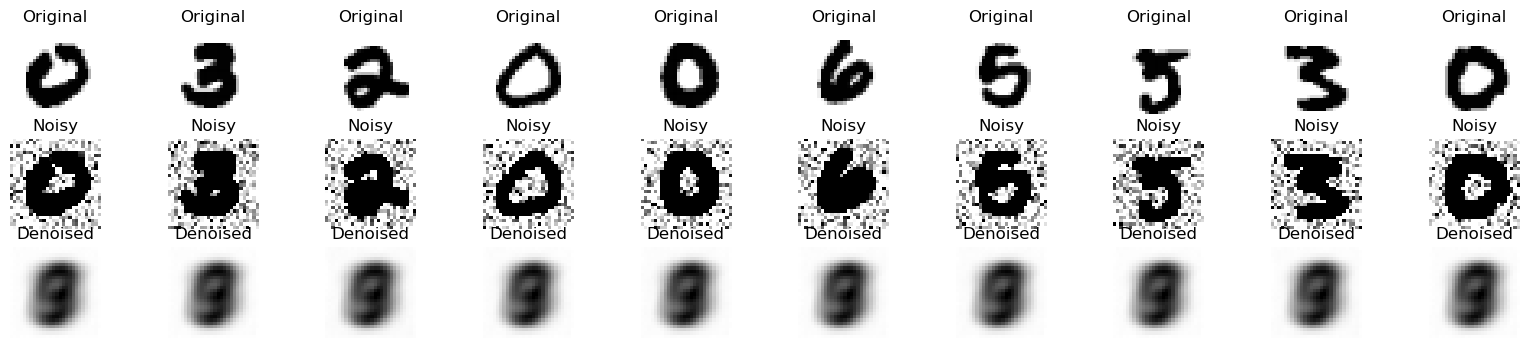

In [47]:
# Detect outliers
outliers = reconstruction_error > threshold

# Denoise the test images
x_test_denoised = hvae.predict(x_test_noisy)

# Plot some outliers
plot_images(x_test[outliers][:10], x_test_noisy[outliers][:10], x_test_denoised[outliers][:10], n=10)

In [48]:
# Detect noisy images
reconstructions = hvae.predict(x_test_noisy)
mse = np.mean(np.power(x_test_noisy - reconstructions, 2), axis=(1, 2,3))

313/313 [==============================] - 3s 9ms/step


In [49]:
# Set a threshold for noisy images
threshold = np.percentile(mse, 95)  # 95th percentile of MSE
noisy_images = mse > threshold

In [50]:
# Filter out noisy images
clean_images = x_test[~noisy_images]

In [51]:
# Function to display a list of images
def plot_images(images, nrows, ncols, cmap='gray'):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].reshape(28, 28), cmap=cmap)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

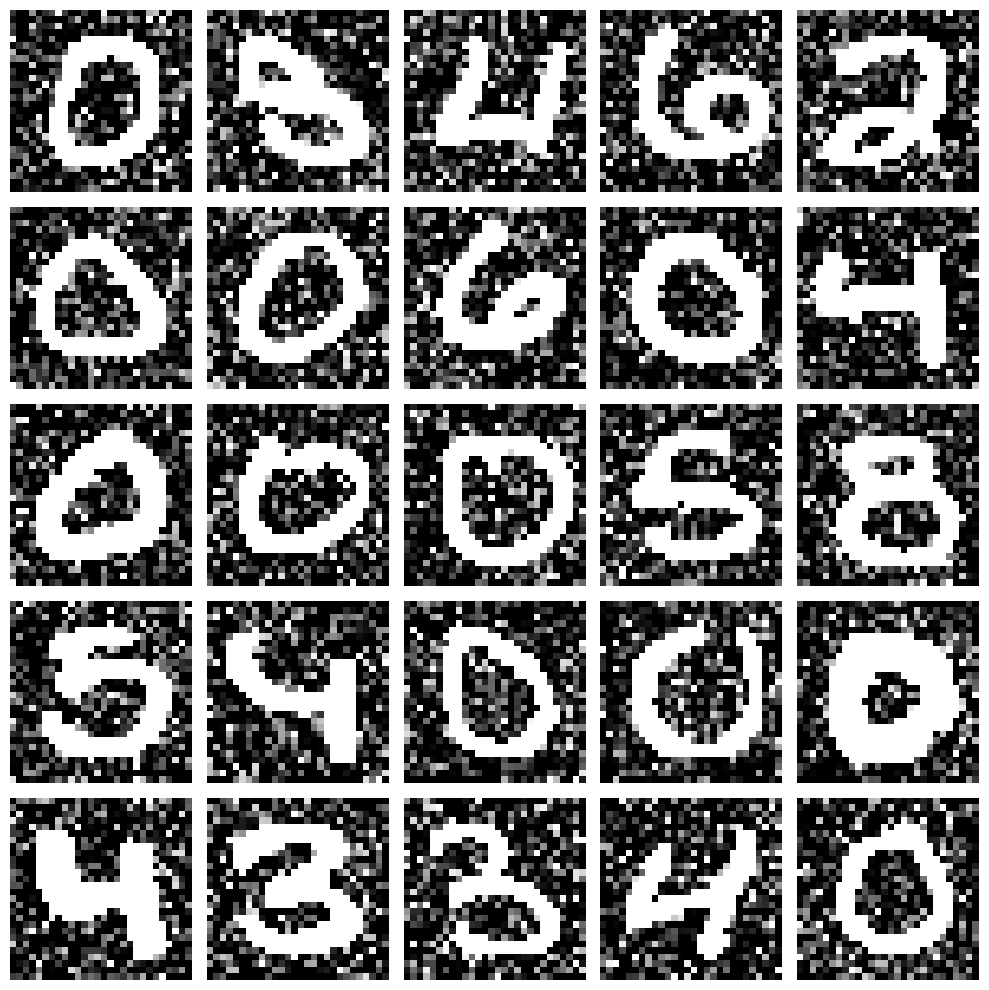

In [52]:
#Display original noisy images
plot_images(x_test_noisy[noisy_images][:25], 5, 5)

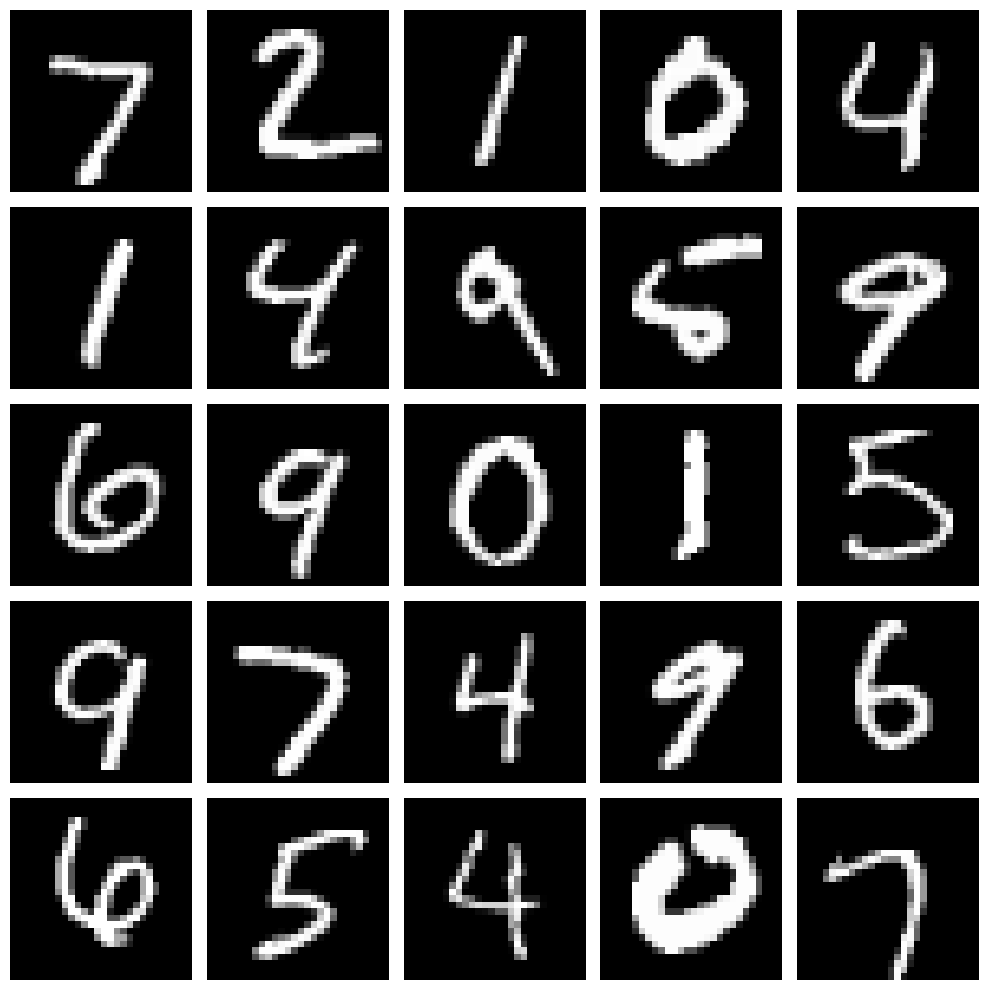

In [53]:
# Display clean images after removing noisy ones
plot_images(clean_images[:25], 5, 5)